In [1]:
import torch
import torch.nn as nn
import contextlib
import warnings
import math
import numpy as np


def get_jet_relvars_jv(four_vec, four_vec_cy, jet_four_vec_cy):
    
    pi = torch.tensor(math.pi)
    # log(E)
    log_E = torch.log(four_vec_cy[:,:,0])
    
    # log(pT)
    log_pt = torch.log(four_vec_cy[:,:,1])
    
    # log(E_const/E_jet)
    log_Er = torch.log((four_vec_cy[:,:,0]/jet_four_vec_cy[:,:,0]))

    # log(pt_const/pt_jet)
    log_ptr = torch.log((four_vec_cy[:,:,1]/jet_four_vec_cy[:,:,1]))

    # dEta
    dEta =  four_vec_cy[:,:,2] - jet_four_vec_cy[:,:,2]

    # dPhi
    dPhi =  four_vec_cy[:,:,3] - jet_four_vec_cy[:,:,3] 
    dPhi[dPhi>pi] -=  2*pi
    dPhi[dPhi<= - pi] +=  2*pi

    # dR
    dR = torch.sqrt(dEta**2 + dPhi**2)

    
    # order of features [dEta, dPhi, log_R_pt, log_Pt, log_R_E, log_E, dR]
    jet_features = torch.cat([
        dEta.unsqueeze(-1), 
        dPhi.unsqueeze(-1),
        log_ptr.unsqueeze(-1),
        log_pt.unsqueeze(-1),
        log_Er.unsqueeze(-1),
        log_E.unsqueeze(-1),
        dR.unsqueeze(-1)
    ], axis=2)

    zero_mask = (four_vec == 0.0).any(dim=-1, keepdim=True)
    zero_mask = zero_mask.expand_as(jet_features)
    jet_features[zero_mask] = 0.0
    
    return jet_features

def inverse_jet_relvars_to_cartesian(jet_features, jet_four_vec_cy):
    """
    Reconstruct four_vec (Cartesian 4-vector) from jet_features and jet_four_vec_cy.
    """
    # Extract components from jet_features
    dEta = jet_features[:,:,0]
    dPhi = jet_features[:,:,1]
    log_ptr = jet_features[:,:,2]
    log_pt = jet_features[:,:,3]
    log_Er = jet_features[:,:,4]
    log_E = jet_features[:,:,5]
    
    # Extract components from jet_four_vec_cy (which are in regular E, pT, eta, phi)
    E_jet = jet_four_vec_cy[:,:,0]
    pT_jet = jet_four_vec_cy[:,:,1]
    eta_jet = jet_four_vec_cy[:,:,2]
    phi_jet = jet_four_vec_cy[:,:,3]

    # Reconstruct cylindrical coordinates
    eta = eta_jet + dEta
    phi = phi_jet + dPhi
    phi = torch.remainder(phi + math.pi, 2 * math.pi) - math.pi  # Ensure phi is in [-pi, pi]
    
    # Reconstruct E and pT from their log ratios
    E_const = E_jet * torch.exp(log_Er)
    pT_const = pT_jet * torch.exp(log_ptr)

    # Convert cylindrical coordinates back to Cartesian
    px = pT_const * torch.cos(phi)
    py = pT_const * torch.sin(phi)
    pz = pT_const * torch.sinh(eta)

    # Stack components into a Cartesian 4-vector
    four_vec = torch.stack([E_const, px, py, pz], dim=-1)  # Shape [B, N, 4]
    
    return four_vec


def to_cylindrical(four_vec, log=True):
    E = four_vec[:,:,0]
    px = four_vec[:,:,1]
    py = four_vec[:,:,2]
    pz = four_vec[:,:,3]
    pt = torch.sqrt(px*px + py*py)
    phi = torch.arctan2(py,px)
    eta = torch.arcsinh(pz/pt)

    if log:
        cylindrical_four_vec = torch.cat([
            torch.log(E.unsqueeze(-1)),
            torch.log(pt.unsqueeze(-1)), 
            eta.unsqueeze(-1),
            phi.unsqueeze(-1)
        ], axis=2)

        cylindrical_four_vec = torch.where(cylindrical_four_vec < -1e30, 0, cylindrical_four_vec)
    else:
        cylindrical_four_vec = torch.cat([E.unsqueeze(-1),pt.unsqueeze(-1), eta.unsqueeze(-1),phi.unsqueeze(-1)], axis=2)

    
    return torch.nan_to_num(cylindrical_four_vec)


def create_transformation_dict(cartesian_features):
    # Converts Cartesian coordinates to cylindrical and returns a transformation dict
    # cartesian_features shape [B, N, 4]
    logE, logPt, eta, phi = to_cylindrical(cartesian_features, log=True).unbind(dim=2)
    
    # Intermediate quantities, shape [B, N]
    sin_phi = torch.sin(phi) 
    cos_phi = torch.cos(phi) 
    sinh_eta = torch.sinh(eta)
    cosh_eta = torch.cosh(eta)
    lamb = torch.exp(logE - logPt)
    zeros = torch.zeros_like(logE)
    ones = torch.ones_like(logE)
    
    # Create and return the transformation dictionary
    # Each key corresponds to a different coordinate
    # Each value is a tensor of shape [B, N, 6]
    trans_dict = {}
    trans_dict['logE'] = torch.stack([zeros]*3 + [cos_phi/lamb, sin_phi/lamb, sinh_eta/lamb], dim=2)
    trans_dict['logPt'] = torch.stack([-sin_phi*sinh_eta, cos_phi*sinh_eta, zeros, cos_phi*lamb, sin_phi*lamb, zeros], dim=2)
    trans_dict['eta'] = torch.stack([cosh_eta*sin_phi, -cosh_eta*cos_phi, zeros, -lamb*cos_phi*sinh_eta/cosh_eta, -lamb*sin_phi*sinh_eta/cosh_eta, lamb/cosh_eta], dim=2)
    trans_dict['phi'] = torch.stack([-cos_phi*sinh_eta, -sin_phi*sinh_eta, ones, -lamb*sin_phi, lamb*cos_phi, zeros], dim=2)
    return trans_dict

def symm_loss_scalar7(model, X, X_cartesian, jet_vec, mask=None, train=False, generators=None):
    # generator should be a list of 6 boolian values, indicating which of the 6 Lorentz generators to use
     # Check if generators is a list of boolean values
    if generators is not None:
        if not isinstance(generators, list) or len(generators) != 6 or not all(isinstance(g, bool) for g in generators):
            warnings.warn("Invalid 'generators'. Expected a list of 6 boolean values. Continuing with 'generators=None'.")
            generators = None
    
    device = X.device
    
    model = model.to(device) # Probably not necessary, I assume the model is already on the correct device
    

    # Create transformation dict for particles and jets
    trans_dict = create_transformation_dict(X_cartesian)
    trans_dict_jet = create_transformation_dict(jet_vec)
    
    # Prepare input
    input = X.clone().detach().requires_grad_(True).to(device)
    model.eval()
    output = model(input, mask)  # [B]
    
    # Compute gradients
    grads, = torch.autograd.grad(
        outputs=output, 
        inputs=input, 
        grad_outputs=torch.ones_like(output, device=device), 
        create_graph=train
    )
    
    
    with contextlib.nullcontext() if train else torch.no_grad():
        # Build the variation tensor [B,6]
        var_tensor = torch.einsum('b n, b n k -> b k',grads[:,:,0], (trans_dict['eta'] - trans_dict_jet['eta']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,1], (trans_dict['phi'] - trans_dict_jet['phi']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,2], (trans_dict['logPt'] - trans_dict_jet['logPt']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,3], trans_dict['logPt'])
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,4], (trans_dict['logE'] - trans_dict_jet['logE']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,5], trans_dict['logE'])
        
        # delta R calculation (K_tensor)
        K_tensor = (input[:,:,0].unsqueeze(-1) * (trans_dict['eta'] - trans_dict_jet['eta']))
        K_tensor += (input[:,:,1].unsqueeze(-1) * (trans_dict['phi'] - trans_dict_jet['phi']))
        K_tensor /= input[:,:,6].unsqueeze(-1)+1e-10 # Avoid division by zero
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,6], K_tensor)


        # Apply generators mask if provided
        if generators is not None:
            generators_tensor = torch.tensor(generators, dtype=torch.bool, device=device).unsqueeze(0)  # [1, 6]
            var_tensor = torch.where(generators_tensor, var_tensor, torch.zeros_like(var_tensor))

        
        # Compute the loss
        loss = torch.norm(var_tensor, p=2, dim=1)**2
        return loss.mean()





In [7]:
loss = nn.MSELoss(reduction = 'sum')
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [8]:
output

tensor(26.0591, grad_fn=<MseLossBackward0>)

In [2]:
# Simulated dataset for massless 4-vectors
B, N = 126, 20  # Batch size, number of particles

# Random momentum vectors
p = torch.randn(B, N, 3)

# Compute energy E = sqrt(px^2 + py^2 + pz^2) to make the 4-vector massless
E = p.norm(dim=-1)

# Stack E and p into a 4-vector
four_vec = torch.cat([E.unsqueeze(-1), p], dim=-1)  # Shape [B, N, 4]
# four_vec = torch.stack([E, px, py, pz], dim=-1)  # Shape [B, N, 4]

# Convert to cylindrical coordinates
four_vec_cy = to_cylindrical(four_vec, log=False)

# Compute the jet 4-vector as the sum over N particles
jet_vec = torch.sum(four_vec, dim=1, keepdim=True)  # Shape [B, 1, 4]

# Convert jet vector to cylindrical coordinates
jet_four_vec_cy = to_cylindrical(jet_vec, log=False)


In [278]:
jet_features = get_jet_relvars_jv(four_vec, four_vec_cy, jet_four_vec_cy)

# test the conversion back to 4-vectors
reconstructed_four_vec = inverse_jet_relvars_to_cartesian(jet_features, jet_four_vec_cy)
# check if the reconstructed 4-vectors are the same as the original 4-vectors
print(f'Are the reconstructed 4-vectors the same as the original 4-vectors? {torch.allclose(four_vec, reconstructed_four_vec, atol=1e-5)}')


Are the reconstructed 4-vectors the same as the original 4-vectors? True


In [279]:
class DummyModel(nn.Module):
    def forward(self, input, mask=None):
        # Simple model: sum over all particles and features
        return torch.sum(input, dim=[1, 2])  # Output shape [B]

class DummyModel2(nn.Module):
    """
    This model uses inverse_jet_relvars_to_cartesian(input, self.jet_four_vec_cy)
    to reconstruct 4-vectors, then calculates a Lorentz invariant scalar.
    Specifically:
    - Calculates jet mass using the Minkowski metric from the sum of 4-vectors (jet 4-vector).
    - Calculates the sum of (4-dot product of jet and particle 4-vectors)^2.
    """
    def __init__(self, jet_four_vec_cy):
        super(DummyModel2, self).__init__()
        self.jet_four_vec_cy = jet_four_vec_cy
        self.mink_metric = torch.tensor([1, -1, -1, -1], dtype=torch.float32)  # Minkowski metric [1, -1, -1, -1]

    def forward(self, input, mask=None):
        # Reconstruct the particle 4-vectors from input and jet cylindrical vector
        four_vec = inverse_jet_relvars_to_cartesian(input, self.jet_four_vec_cy)  # Shape [B, N, 4]

        # Compute the jet 4-vector as the sum over particles (Cartesian 4-vector)
        jet_vec = torch.sum(four_vec, dim=1, keepdim=True)  # Shape [B, 1, 4]

        # Calculate the jet mass using Minkowski metric: jet_mass^2 = E^2 - p_x^2 - p_y^2 - p_z^2
        jet_mass_sq = torch.sum(jet_vec * jet_vec * self.mink_metric, dim=2).squeeze(1)  # Shape [B]
        
        

        # Calculate the dot product of each particle's 4-vector with the jet 4-vector
        dot_product = torch.sum(four_vec * jet_vec * self.mink_metric, dim=2)  # Shape [B, N]

        # Sum of squared dot products
        dot_product_sum = torch.mean(dot_product ** 2, dim=1)  # Shape [B]

        # Return jet mass (broadcasted to [B]) + sum of squared dot products
        return dot_product_sum #jet_mass_sq

In [280]:
model = DummyModel2(jet_four_vec_cy)
loss = symm_loss_scalar7(model, jet_features, four_vec_cy, jet_vec)

In [281]:
for n in range(6):
    
    generators = [False]*n+[True]+[False]*(5-n)
    print(generators,symm_loss_scalar7(model, jet_features, four_vec_cy, jet_vec, generators=generators).item())
    

[True, False, False, False, False, False] 12920633.0
[False, True, False, False, False, False] 48626032.0
[False, False, True, False, False, False] 0.0
[False, False, False, True, False, False] 1717492736.0
[False, False, False, False, True, False] 388343200.0
[False, False, False, False, False, True] 23837744.0


In [282]:
(four_vec*four_vec*torch.tensor([1, -1, -1, -1])).sum(dim=2)

tensor([[-2.0082e-08,  0.0000e+00, -1.1176e-08,  ..., -1.8626e-07,
         -1.4901e-07,  0.0000e+00],
        [ 1.7881e-07, -2.9802e-08,  1.4901e-07,  ...,  0.0000e+00,
         -2.3842e-07, -1.1176e-08],
        [-2.9802e-08, -5.9605e-08,  0.0000e+00,  ...,  1.1921e-07,
          9.6858e-08, -2.3842e-07],
        ...,
        [-2.3842e-07,  0.0000e+00,  1.4901e-08,  ...,  4.4703e-08,
         -1.6764e-07,  5.9605e-08],
        [ 2.3842e-07,  8.1956e-08,  0.0000e+00,  ..., -5.9605e-08,
          1.6391e-07,  1.4901e-07],
        [ 1.9372e-07, -4.6566e-09, -1.7881e-07,  ...,  1.8626e-08,
          8.9407e-08,  1.1921e-07]])

In [284]:
class ContivedModel(nn.Module):
    """
    This model uses inverse_jet_relvars_to_cartesian(input, self.jet_four_vec_cy)
    to reconstruct 4-vectors, then calculates a Lorentz invariant scalar.
    Specifically:
    - Calculates jet mass using the Minkowski metric from the sum of 4-vectors (jet 4-vector).
    - Calculates the sum of (4-dot product of jet and particle 4-vectors)^2.
    """
    def __init__(self):
        super(ContivedModel, self).__init__()
        self.mink_metric = torch.tensor([1, -1, -1, -1], dtype=torch.float32)  # Minkowski metric [1, -1, -1, -1]

    def forward(self, x, mask=None):
        # input is shape [B, N, 4], where the last dimension is [E, px, py, pz]
        # input is the version of x that requires grad
        input = x.clone().detach().requires_grad_(True)
        
        # Jet 4-vector is the sum of all particles
        jet_vec = torch.sum(input, dim=1, keepdim=True)

        # Calculate the jet mass, this is going to be the output.
        jet_mass_sq = torch.einsum('...n,n->...', jet_vec * jet_vec, self.mink_metric).squeeze(1)

        # convert input and jet_vec to cylindrical coordinates, and get the 7 features for each particle
        input_cy = to_cylindrical(input, log=False)
        jet_vec_cy = to_cylindrical(jet_vec, log=False)
        jet_features = get_jet_relvars_jv(input, input_cy, jet_vec_cy) # Shape [B, N, 7]
        

        # get gradients of both outputs and features with respect to input
        grads_output, = torch.autograd.grad(
            outputs=jet_mass_sq,
            inputs=input,
            grad_outputs=torch.ones_like(jet_mass_sq),
            create_graph=False
        )
        
        # Compute the gradient of each feature w.r.t. each particle's 4-vector.
        B, N, _ = input.shape
        grads_features = torch.zeros(B, N, 7, N, 4, device=input.device)

        # Loop through each particle's features (loop only over N and 7)
        for n in range(N):
            for feature_idx in range(7):
                # Get the single scalar feature for particle n, feature_idx
                feature = jet_features[:, n, feature_idx]  # Shape [B]
                
                # Compute the gradient of this feature w.r.t. the input
                grad_feature, = torch.autograd.grad(
                    outputs=feature,
                    inputs=input,
                    grad_outputs=torch.ones_like(feature),
                    retain_graph=True,
                    create_graph=True
                )
                
                # Store the gradient [B, N, 4] for each feature in grads_features
                grads_features[:, n, feature_idx] = grad_feature

        return jet_mass_sq, jet_features, grads_output, grads_features



In [285]:
import torch

class ContivedModel(torch.nn.Module):
    def __init__(self):
        super(ContivedModel, self).__init__()
        self.mink_metric = torch.tensor([1, -1, -1, -1], dtype=torch.float32)

    def forward(self, x, mask=None):
        input = x.clone().detach().requires_grad_(True)

        # Jet 4-vector is the sum of all particles
        jet_vec = torch.sum(input, dim=1, keepdim=True)

        # Calculate the jet mass, this is going to be the output.
        jet_mass_sq = torch.einsum('...n,n->...', jet_vec * jet_vec, self.mink_metric).squeeze(1)

        # Convert input and jet_vec to cylindrical coordinates, and get the 7 features for each particle
        input_cy = to_cylindrical(input, log=False)
        jet_vec_cy = to_cylindrical(jet_vec, log=False)
        jet_features = get_jet_relvars_jv(input, input_cy, jet_vec_cy)  # Shape [B, N, 7]

        # Get gradients of jet mass w.r.t. input (shape [B, N, 4])
        grads_output, = torch.autograd.grad(
            outputs=jet_mass_sq,
            inputs=input,
            grad_outputs=torch.ones_like(jet_mass_sq),
            create_graph=True
        )

        # Compute the gradient of each feature w.r.t. each particle's 4-vector
        B, N, _ = input.shape
        grads_features_wrt_input = torch.zeros(B, N, 7, N, 4, device=input.device)

        # Loop through each particle's features (loop only over N and 7)
        for n in range(N):
            for feature_idx in range(7):
                # Get the single scalar feature for particle n, feature_idx
                feature = jet_features[:, n, feature_idx]  # Shape [B]
                
                # Compute the gradient of this feature w.r.t. the input
                grad_feature, = torch.autograd.grad(
                    outputs=feature,
                    inputs=input,
                    grad_outputs=torch.ones_like(feature),
                    retain_graph=True,
                    create_graph=True
                )
                
                # Store the gradient [B, N, 4] for each feature in grads_features_wrt_input
                grads_features_wrt_input[:, n, feature_idx] = grad_feature

        # Reshape and transpose for matrix multiplication
        # Flatten grads_output to [B, 4*N]
        grads_output_flat = grads_output.reshape(B, 4 * N)  # [B, 4*N]
        
        # Flatten grads_features_wrt_input to [B, 4*N, 7*N] by using view and transpose
        grads_features_wrt_input_flat = grads_features_wrt_input.view(B, 7 * N, 4 * N).transpose(1, 2)

        # Compute the pseudo-inverse of the Jacobian
        dJetMassSq_dFeatures = torch.zeros(B, 7 * N, device=input.device)
        
        for b in range(B):
            # Compute the pseudo-inverse for each batch
            pseudo_inv = torch.pinverse(grads_features_wrt_input_flat[b])  # [7*N, 4*N]

            # Multiply the pseudo-inverse with the flattened grads_output
            dJetMassSq_dFeatures[b] = torch.matmul(pseudo_inv, grads_output_flat[b])

        # Reshape the result back to [B, N, 7] (particle and feature dimensions)
        dJetMassSq_dFeatures = dJetMassSq_dFeatures.view(B, N, 7)

        return jet_mass_sq.detach(), jet_features.detach(), jet_vec.detach(), dJetMassSq_dFeatures.detach()


In [286]:
model = ContivedModel()
jet_mass_sq, jet_features, jet_vec, dJetMassSq_dFeatures = model(four_vec)
# grads_output.shape, grads_features_wrt_input.shape, dJetMassSq_dFeatures.shape

In [53]:
def create_transformation_dict(cartesian_features):
    # Converts Cartesian coordinates to cylindrical and returns a transformation dict
    # cartesian_features shape [B, N, 4]
    logE, logPt, eta, phi = to_cylindrical(cartesian_features, log=True).unbind(dim=2)
    
    # Intermediate quantities, shape [B, N]
    sin_phi = torch.sin(phi) 
    cos_phi = torch.cos(phi) 
    sinh_eta = torch.sinh(eta)
    cosh_eta = torch.cosh(eta)
    lamb = torch.exp(logE - logPt)
    zeros = torch.zeros_like(logE)
    ones = torch.ones_like(logE)
    
    # Create and return the transformation dictionary
    # Each key corresponds to a different coordinate
    # Each value is a tensor of shape [B, N, 6]
    trans_dict = {}
    trans_dict['logE'] = torch.stack([zeros]*3 + [cos_phi/lamb, sin_phi/lamb, sinh_eta/lamb], dim=2)
    trans_dict['logPt'] = torch.stack([sin_phi*sinh_eta, -cos_phi*sinh_eta, zeros, lamb*cos_phi, lamb*sin_phi, zeros], dim=2)
    trans_dict['eta'] = torch.stack([-cosh_eta*sin_phi, cosh_eta*cos_phi, zeros, -lamb*cos_phi*sinh_eta/cosh_eta, -lamb*sin_phi*sinh_eta/cosh_eta, lamb/cosh_eta], dim=2)
    trans_dict['phi'] = torch.stack([cos_phi*sinh_eta, sin_phi*sinh_eta, -ones, -lamb*sin_phi, lamb*cos_phi, zeros], dim=2)
    return trans_dict


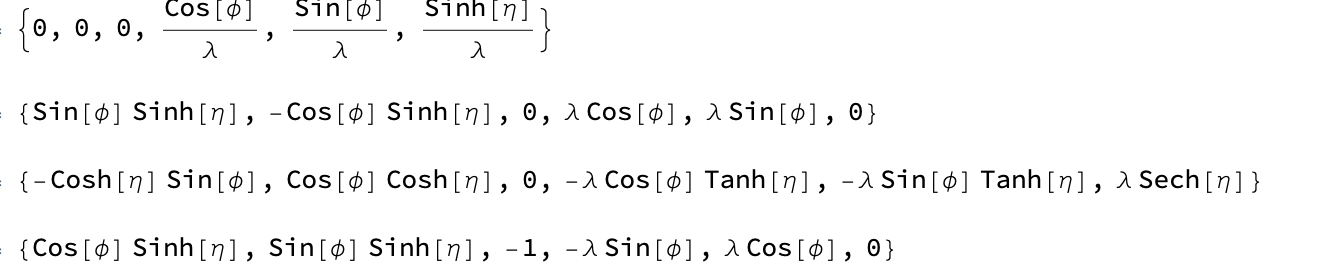

In [39]:
def symm_loss_scalar7_debug(grads, X7, X_cartesian, jet_vec, generators=None, train=False):
    # generator should be a list of 6 boolian values, indicating which of the 6 Lorentz generators to use
     # Check if generators is a list of boolean values
    if generators is not None:
        if not isinstance(generators, list) or len(generators) != 6 or not all(isinstance(g, bool) for g in generators):
            warnings.warn("Invalid 'generators'. Expected a list of 6 boolean values. Continuing with 'generators=None'.")
            generators = None
    
    device = X7.device
    
    

    # Create transformation dict for particles and jets
    trans_dict = create_transformation_dict(X_cartesian)
    trans_dict_jet = create_transformation_dict(jet_vec)
    
    
    
    with contextlib.nullcontext() if train else torch.no_grad():
        # Build the variation tensor [B,6]
        var_tensor = torch.einsum('b n, b n k -> b k',grads[:,:,0], (trans_dict['eta'] - trans_dict_jet['eta']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,1], (trans_dict['phi'] - trans_dict_jet['phi']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,2], (trans_dict['logPt'] - trans_dict_jet['logPt']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,3], trans_dict['logPt'])
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,4], (trans_dict['logE'] - trans_dict_jet['logE']))
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,5], trans_dict['logE'])
        
        # delta R calculation (K_tensor)
        K_tensor = (X7[:,:,0].unsqueeze(-1) * (trans_dict['eta'] - trans_dict_jet['eta']))
        K_tensor += (X7[:,:,1].unsqueeze(-1) * (trans_dict['phi'] - trans_dict_jet['phi']))
        K_tensor /= X7[:,:,6].unsqueeze(-1)+1e-10 # Avoid division by zero
        var_tensor += torch.einsum('b n, b n k -> b k',grads[:,:,6], K_tensor)


        # Apply generators mask if provided
        if generators is not None:
            generators_tensor = torch.tensor(generators, dtype=torch.bool, device=device).unsqueeze(0)  # [1, 6]
            var_tensor = torch.where(generators_tensor, var_tensor, torch.zeros_like(var_tensor))

        
        # Compute the loss
        loss = torch.norm(var_tensor, p=2, dim=1)**2
        return loss.mean()



In [301]:
model = ContivedModel()
jet_mass_sq, jet_features, jet_vec, dJetMassSq_dFeatures = model(four_vec)
for n in range(6):
    
    generators = [False]*n+[True]+[False]*(5-n)
    
    print(generators,symm_loss_scalar7_debug(dJetMassSq_dFeatures, jet_features, four_vec, jet_vec, generators=generators).item())

[True, False, False, False, False, False] 0.8026242256164551
[False, True, False, False, False, False] 1.1303021907806396
[False, False, True, False, False, False] 0.0
[False, False, False, True, False, False] 11.569864273071289
[False, False, False, False, True, False] 3.887751579284668
[False, False, False, False, False, True] 0.6029816269874573


In [289]:
symm_loss_scalar7_debug(dJetMassSq_dFeatures, jet_features, four_vec, jet_vec)

tensor(17.9935)

In [40]:
p = torch.randn(10,3)
E = p.norm(dim=-1)
P = torch.cat([E.unsqueeze(-1),p],dim=1).unsqueeze(0)

In [41]:
P

tensor([[[ 0.6076,  0.4468, -0.2869,  0.2954],
         [ 0.7405,  0.6726,  0.0499, -0.3055],
         [ 1.9375,  1.4218,  0.7007, -1.1143],
         [ 1.5301, -1.3314,  0.4298,  0.6195],
         [ 1.3119,  0.3953,  1.2402,  0.1633],
         [ 0.6421, -0.0828,  0.5735,  0.2767],
         [ 1.2475, -1.0370,  0.5688, -0.3966],
         [ 1.5655,  0.5462, -0.1260,  1.4618],
         [ 2.2024, -0.0066, -1.1691, -1.8664],
         [ 1.1250, -0.6374, -0.4817,  0.7921]]])

In [52]:
def extract_jet_features(P):
    P_cy = to_cylindrical(P, log=False)
    P_jet = torch.sum(P, dim=1, keepdim=True)
    P_jet_cy = to_cylindrical(P_jet, log=False)
    P_features = get_jet_relvars_jv(P, P_cy, P_jet_cy)
    return P_features

# generate small random data [10,4]
P7 = extract_jet_features(P).squeeze(0)

# small x-z plane rotation
theta = torch.tensor(1e-5)
beta = torch.tensor(1e-5)
P_rot = P.clone()
rot_matrix4Dxz = torch.tensor([[1,0,0,0],[0,torch.cos(theta),0,-torch.sin(theta)],[0,0,1,0],[0,torch.sin(theta),0,torch.cos(theta)]])
rot_matrix4Dxy = torch.tensor([[1,0,0,0],[0,torch.cos(theta),-torch.sin(theta),0],[0,torch.sin(theta),torch.cos(theta),0],[0,0,0,1]])
# boost in a given direction by beta
boost_matrix4Dx = torch.tensor([[torch.cosh(beta),torch.sinh(beta),0,0],[-torch.sinh(beta),torch.cosh(beta),0,0],[0,0,1,0],[0,0,0,1]])
boost_matrix4Dy = torch.tensor([[torch.cosh(beta),0,torch.sinh(beta),0],[0,1,0,0],[torch.sinh(beta),0,torch.cosh(beta),0],[0,0,0,1]])
boost_matrix4Dz = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,torch.cosh(beta),torch.sinh(beta)],[0,0,torch.sinh(beta),torch.cosh(beta)]])
# rot_matrix4Dxt
P_rot = torch.matmul(P_rot,boost_matrix4Dz)
P7_rot = extract_jet_features(P_rot).squeeze(0)

delta_P7 = (P7_rot - P7)/beta
delta_P7[:,-4]

dici = create_transformation_dict(P)
dici['logPt'][:,:,-1]/delta_P7[:,-4]



# order of features [dEta, dPhi, log_R_pt, log_Pt, log_R_E, log_E, dR]


logE: tensor([[inf, -inf, -inf, inf, inf, inf, -inf, inf, -inf, inf]])
logPt: tensor([[-0., -0., -0., 0., 0., 0., -0., -0., 0., -0.]])


KeyError: 'eta'

In [50]:
dici.keys()

dict_keys(['logE', 'logPt', 'eta', 'phi'])

In [51]:
delta_P7

tensor([[-1.2755,  0.4888, -0.2384, -0.3040,  0.0000,  0.0000, -0.8464],
        [-0.9000, -0.4411,  0.0238, -0.0358,  0.0000,  0.0000,  0.6914],
        [-0.7689, -0.6199, -0.2446, -0.3099,  0.0000,  0.0000,  0.9418],
        [-0.7302, -0.3934,  0.1974,  0.1341,  0.0000,  0.0000, -0.5960],
        [-0.0238,  0.0477,  0.1922,  0.1281,  0.0000,  0.0000, -0.0373],
        [-0.2623, -0.0596,  0.5245,  0.4649,  0.0000,  0.0000, -0.2444],
        [-0.5543,  0.2980, -0.1103, -0.1714,  0.0000,  0.0000,  0.4053],
        [-0.5007,  2.5630, -0.5126, -0.5841,  0.0000,  0.0000, -2.0504],
        [-0.1431,  0.0238,  1.6481,  1.5914,  0.0000,  0.0000,  0.0000],
        [-0.9596, -0.7868, -0.5424, -0.6035,  0.0000,  0.0000, -1.0729]])

In [16]:
import einops
import numpy as np
from top_symm_loss_defs import *

Using cuda device


In [21]:
def Lorentz_Trans(data,beta,beta_dir = torch.tensor([1,0,0])):
    data = data.to(devicef)
    gamma = 1/np.sqrt(1-beta**2)
    beta_dir = beta_dir/(torch.sqrt(torch.sum(beta_dir**2)))
    # LorentzBoost = torch.tensor([[gamma, -gamma*beta,  0, 0],[-gamma*beta, gamma, 0, 0],[0,0,1,0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    LorentzBoost = torch.diag(torch.tensor([gamma,1,1,1],dtype = torch.float32)).to(devicef)
    for i in range(1,4):
        LorentzBoost[0,i] += -gamma*beta*beta_dir[i-1]
        LorentzBoost[i,0] += -gamma*beta*beta_dir[i-1]
        for j in range(1,4):
            LorentzBoost[i,j] += 0.5*(gamma-1)*beta_dir[i-1]*beta_dir[j-1]
            LorentzBoost[j,i] += 0.5*(gamma-1)*beta_dir[i-1]*beta_dir[j-1]
    d = 4
    data = einops.rearrange(data, '... (N d) -> ... N d',d = 4)
    trans_data = torch.einsum("ij,...j-> ...i",LorentzBoost,data).to(devicef)
    trans_data = einops.rearrange(trans_data, '... N d -> ... (N d)', d = 4)
    # print(LorentzBoost)
    return trans_data

In [19]:
def rot(data,theta,theta_dir = torch.tensor([0,0,1])):
    theta_dir = (theta_dir.to(devicef)/(torch.sqrt(torch.sum(theta_dir**2))))
    # rotate = torch.tensor([[1, 0,  0, 0],[0, np.cos(theta), np.sin(theta), 0],[0,-np.sin(theta),np.cos(theta),0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    
    rotate = torch.diag(torch.tensor([1,1,1,1],dtype = torch.float32)).to(devicef)
    L_gens = gens_Lorentz[3::].to(devicef)
    e_L_gens = torch.einsum("i,ijk-> jk",theta_dir,L_gens).to(devicef)
    rotate = rotate+np.sin(theta)*e_L_gens+(1-np.cos(theta))*torch.matmul(e_L_gens,e_L_gens)
    
    data = einops.rearrange(data, '... (N d) -> ... N d',d = 4)
    trans_data = torch.einsum("ij,...j-> ...i",rotate,data).to(devicef)
    trans_data = einops.rearrange(trans_data, '... N d -> ... (N d)', d = 4)
    return trans_data

In [68]:
np.arctanh(beta_val)

1.0000000000333335e-05

In [27]:
P_trans_z

tensor([[[ 2.5921, -0.8946, -2.0957, -1.2356],
         [ 2.2535, -1.7257,  1.3640,  0.4896],
         [ 0.9337,  0.6965, -0.1372,  0.6065],
         [ 2.0049,  1.3920,  1.0572, -0.9822],
         [ 0.9899, -0.5183,  0.7142, -0.4486],
         [ 0.8863, -0.0107, -0.8798, -0.1064],
         [ 1.4226,  1.1438,  0.1438,  0.8336],
         [ 1.4395,  1.3956, -0.2734,  0.2230],
         [ 2.0366,  1.3646,  0.9840,  1.1477],
         [ 2.1046, -1.8813,  0.0457, -0.9423]]], device='cuda:0')

In [28]:
P_rot_z = torch.matmul(P.clone(),boost_matrix4Dz)

In [29]:
P_rot_z

tensor([[[ 2.5921, -0.8946, -2.0957, -1.2356],
         [ 2.2535, -1.7257,  1.3640,  0.4896],
         [ 0.9337,  0.6965, -0.1372,  0.6065],
         [ 2.0049,  1.3920,  1.0572, -0.9821],
         [ 0.9899, -0.5183,  0.7142, -0.4485],
         [ 0.8863, -0.0107, -0.8798, -0.1064],
         [ 1.4226,  1.1438,  0.1438,  0.8336],
         [ 1.4395,  1.3956, -0.2734,  0.2230],
         [ 2.0366,  1.3646,  0.9840,  1.1477],
         [ 2.1046, -1.8813,  0.0457, -0.9423]]])

In [74]:
p = torch.randn(10,3)
E = p.norm(dim=-1)
P = torch.cat([E.unsqueeze(-1),p],dim=1).unsqueeze(0)

In [121]:
beta_val = 1e-5
P_rot = P.clone().to(devicef)
P7 = extract_jet_features(P).squeeze(0).to(devicef)
P_trans_z = Lorentz_Trans(data = P,beta = beta_val,beta_dir = torch.tensor([1,0,0]))
P7_rot = extract_jet_features(P_trans_z).squeeze(0).to(devicef)

delta_P7 = -(P7_rot - P7)/np.arctanh(beta_val)
delta_P7[:,-4]

dici = create_transformation_dict(P_rot)
trans_dict = create_transformation_dict(P_rot)
trans_dict_jet = create_transformation_dict(torch.sum(P.to(devicef), dim=1, keepdim=True))

dici["dEta"] = trans_dict['eta'] - trans_dict_jet['eta']
dici["dPhi"] = trans_dict['phi'] - trans_dict_jet['phi']
dici["log_R_pt"] = (trans_dict['logPt'] - trans_dict_jet['logPt'])
dici["log_R_E"] = (trans_dict['logE'] - trans_dict_jet['logE'])


# delta R calculation (K_tensor)
K_tensor = (P7[:,0].unsqueeze(-1) * (trans_dict['eta'] - trans_dict_jet['eta']))
K_tensor += (P7[:,1].unsqueeze(-1) * (trans_dict['phi'] - trans_dict_jet['phi']))
K_tensor /= P7[:,6].unsqueeze(-1)+1e-10 # Avoid division by zero
dici["dR"] = K_tensor

#dici['logPt'][:,:,-1]/delta_P7[:,-4]
dict_vars = {"dEta":0, "dPhi":1, "log_R_pt":2, "logPt":3, "log_R_E":4, "logE":5, "dR":6}
dict_gens = {"Lx": 0, "Ly": 1,  "Lz":  2,  "Kx":3, "Ky":4, "Kz":5}

for key in dici.keys():
    if key in dict_vars.keys():
        print(f"{key}:\n var ={dici[key][:,:,dict_gens['Kx']]}\n num = {delta_P7[:,dict_vars[key]]}")
        print()

logE:
 var =tensor([[-0.5917,  0.4324, -0.8017, -0.7570, -0.9978, -0.3335,  0.1330, -0.3406,
          0.7937,  0.1970]], device='cuda:0')
 num = tensor([-0.5901,  0.4306, -0.8047, -0.7540, -1.0014, -0.3338,  0.1311, -0.3397,
         0.7987,  0.1982], device='cuda:0')

logPt:
 var =tensor([[-0.8421,  0.4429, -0.8187, -1.1802, -1.0018, -0.7861,  0.3141, -1.6342,
          1.2277,  0.2334]], device='cuda:0')
 num = tensor([-0.8374,  0.4455, -0.8106, -1.1817, -1.0014, -0.7838,  0.3099, -1.6287,
         1.2279,  0.2325], device='cuda:0')

dEta:
 var =tensor([[-0.4829, -0.0918, -0.1415, -0.7304, -0.0874,  0.5728,  0.2148,  1.4303,
          0.7063, -0.1159]], device='cuda:0')
 num = tensor([-0.4768, -0.0924, -0.1416, -0.7331, -0.0879,  0.5603,  0.2146,  1.4186,
         0.7093, -0.1103], device='cuda:0')

dPhi:
 var =tensor([[-0.4080, -0.3430, -1.8454, -0.8454, -1.2735,  0.0657, -2.7572,  0.2053,
         -1.0541, -0.1897]], device='cuda:0')
 num = tensor([-0.4292, -0.3457, -1.8120, -0.85

In [125]:
theta_val = 1e-5
P_rot = P.clone().to(devicef)
P7 = extract_jet_features(P).squeeze(0).to(devicef)
P_trans_z = rot(data = P.to(devicef),theta = theta_val,theta_dir = torch.tensor([0,0,1]))
P7_rot = extract_jet_features(P_trans_z).squeeze(0).to(devicef)

delta_P7 = -(P7_rot - P7)/np.arctanh(beta_val)
delta_P7[:,-4]

dici = create_transformation_dict(P_rot)
trans_dict = create_transformation_dict(P_rot)
trans_dict_jet = create_transformation_dict(torch.sum(P.to(devicef), dim=1, keepdim=True))

dici["dEta"] = trans_dict['eta'] - trans_dict_jet['eta']
dici["dPhi"] = trans_dict['phi'] - trans_dict_jet['phi']
dici["log_R_pt"] = (trans_dict['logPt'] - trans_dict_jet['logPt'])
dici["log_R_E"] = (trans_dict['logE'] - trans_dict_jet['logE'])


# delta R calculation (K_tensor)
K_tensor = (P7[:,0].unsqueeze(-1) * (trans_dict['eta'] - trans_dict_jet['eta']))
K_tensor += (P7[:,1].unsqueeze(-1) * (trans_dict['phi'] - trans_dict_jet['phi']))
K_tensor /= P7[:,6].unsqueeze(-1)+1e-10 # Avoid division by zero
dici["dR"] = K_tensor

#dici['logPt'][:,:,-1]/delta_P7[:,-4]
dict_vars = {"dEta":0, "dPhi":1, "log_R_pt":2, "logPt":3, "log_R_E":4, "logE":5, "dR":6}
dict_gens = {"Lx": 0, "Ly": 1,  "Lz":  2,  "Kx":3, "Ky":4, "Kz":5}

for key in dici.keys():
    if key in dict_vars.keys():
        print(f"{key}:\n var ={dici[key][:,:,dict_gens['Lz']]}\n num = {delta_P7[:,dict_vars[key]]}")
        print()

logE:
 var =tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
 num = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.], device='cuda:0')

logPt:
 var =tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
 num = tensor([-0.0000, -0.0000,  0.0119, -0.0000, -0.0000, -0.0000, -0.0060, -0.0000,
        -0.0000, -0.0000], device='cuda:0')

dEta:
 var =tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
 num = tensor([-0.0000, -0.0000, 0.0015, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000], device='cuda:0')

dPhi:
 var =tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
 num = tensor([-0.0000, 0.0119, -0.0000, -0.0000, -0.0000, 0.0238, -0.0000, -0.0000, -0.0000,
        -0.0000], device='cuda:0')

log_R_pt:
 var =tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
 num = tensor([-0.0000, -0.0000,  0.0119, -0.0000, -0.0000, -0.0000, -0.0238, -0.0000,
        -0.0000, -0.0000], devi

In [96]:
P7[:,dict_vars["logE"]]

tensor([ 0.5174,  0.2415,  0.8873,  0.4384,  1.0477,  0.6875, -0.3873,  0.8571,
         0.6752, -0.1753], device='cuda:0')

In [87]:
P

tensor([[[ 1.6777, -0.9927, -0.9961, -0.9149],
         [ 1.2731,  0.5505, -1.1311,  0.1959],
         [ 2.4286, -1.9471,  1.4088, -0.3496],
         [ 1.5502, -1.1735, -0.4053, -0.9283],
         [ 2.8510, -2.8447,  0.0580, -0.1813],
         [ 1.9887, -0.6633, -1.1127,  1.5090],
         [ 0.6789,  0.0903,  0.4325, -0.5154],
         [ 2.3562, -0.8027, -0.7162,  2.0963],
         [ 1.9645,  1.5592, -0.2527, -1.1680],
         [ 0.8392,  0.1653, -0.7530,  0.3316]]])

In [109]:
P7

tensor([[-0.6225,  0.2672, -1.6022,  0.3410, -2.3509,  0.5174,  0.6774],
        [ 0.1443,  1.5039, -1.7137,  0.2295, -2.6269,  0.2415,  1.5108],
        [-0.1558, -1.1462, -1.0663,  0.8768, -1.9811,  0.8873,  1.1567],
        [-0.7021, -0.1873, -1.7268,  0.2163, -2.4300,  0.4384,  0.7267],
        [-0.0745, -0.5403, -0.8975,  1.0457, -1.8207,  1.0477,  0.5454],
        [ 0.9825,  0.5134, -1.6843,  0.2588, -2.1809,  0.6875,  1.1085],
        [-1.0053, -2.2965, -2.7601, -0.8169, -3.2557, -0.3873,  2.5069],
        [ 1.4096,  0.2087, -1.8701,  0.0730, -2.0113,  0.8571,  1.4250],
        [-0.6955,  2.4611, -1.4860,  0.4572, -2.1931,  0.6752,  2.5575],
        [ 0.4071,  1.2671, -2.2034, -0.2602, -3.0437, -0.1753,  1.3309]],
       device='cuda:0')

In [112]:
P7_rot

tensor([[-0.6225,  0.2672, -1.6022,  0.3410, -2.3509,  0.5174,  0.6774],
        [ 0.1443,  1.5039, -1.7137,  0.2295, -2.6269,  0.2415,  1.5108],
        [-0.1558, -1.1462, -1.0663,  0.8768, -1.9811,  0.8873,  1.1567],
        [-0.7021, -0.1873, -1.7269,  0.2163, -2.4300,  0.4384,  0.7267],
        [-0.0745, -0.5402, -0.8975,  1.0457, -1.8207,  1.0477,  0.5454],
        [ 0.9825,  0.5134, -1.6844,  0.2588, -2.1809,  0.6875,  1.1085],
        [-1.0053, -2.2965, -2.7601, -0.8169, -3.2557, -0.3873,  2.5069],
        [ 1.4096,  0.2087, -1.8701,  0.0730, -2.0113,  0.8571,  1.4250],
        [-0.6955,  2.4611, -1.4860,  0.4571, -2.1931,  0.6752,  2.5575],
        [ 0.4071,  1.2671, -2.2034, -0.2602, -3.0437, -0.1753,  1.3309]],
       device='cuda:0')